<a href="https://colab.research.google.com/github/bhanmrinal/Machine-Learning-Algorithms/blob/main/Infloso_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Employee Churn Prediction**
*Created By: Mrinal Bhan*


In [ ]:
# Importing neccessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter

# ignore warning
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick # for showing percentage in it

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving churn.csv to churn (1).csv


In [ ]:
data = pd.read_csv('churn.csv')
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
# Features types
data.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

#### Separate into Numerical and Categorical feature

In [ ]:
# numerical feature
numerical_feature = {feature for feature in data.columns if data[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(f'Numerical feature are:\n {numerical_feature}')

Count of Numerical feature: 4
Numerical feature are:
 {'target', 'city_development_index', 'enrollee_id', 'training_hours'}


In [ ]:
# Categorical feature
categorical_feature = {feature for feature in data.columns if data[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(f'Categorical feature are:\n {categorical_feature}')

Count of Categorical feature: 10
Categorical feature are:
 {'company_type', 'last_new_job', 'relevent_experience', 'enrolled_university', 'education_level', 'gender', 'city', 'experience', 'company_size', 'major_discipline'}


## EDA

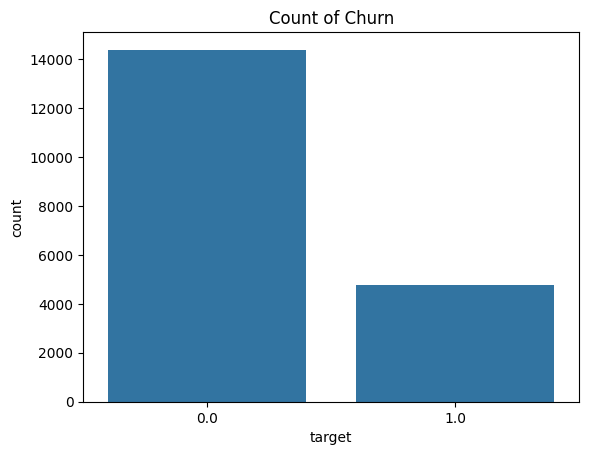

In [ ]:
# plotting with target feature
sns.countplot(data=data, x='target')
plt.title('Count of Churn')
plt.show()

In [ ]:
# Assuming 'target' is the target variable (employee leaving)
num_left = len(data[data['target'] == 1])
total_employees = len(data)
percent_left = num_left / total_employees

print(f"Number of Employees Left: {num_left}")
print(f"Percentage of Employees Left: {percent_left:.2%}")

print(data['target'].value_counts())

Number of Employees Left: 4777
Percentage of Employees Left: 24.93%
0.0    14381
1.0     4777
Name: target, dtype: int64


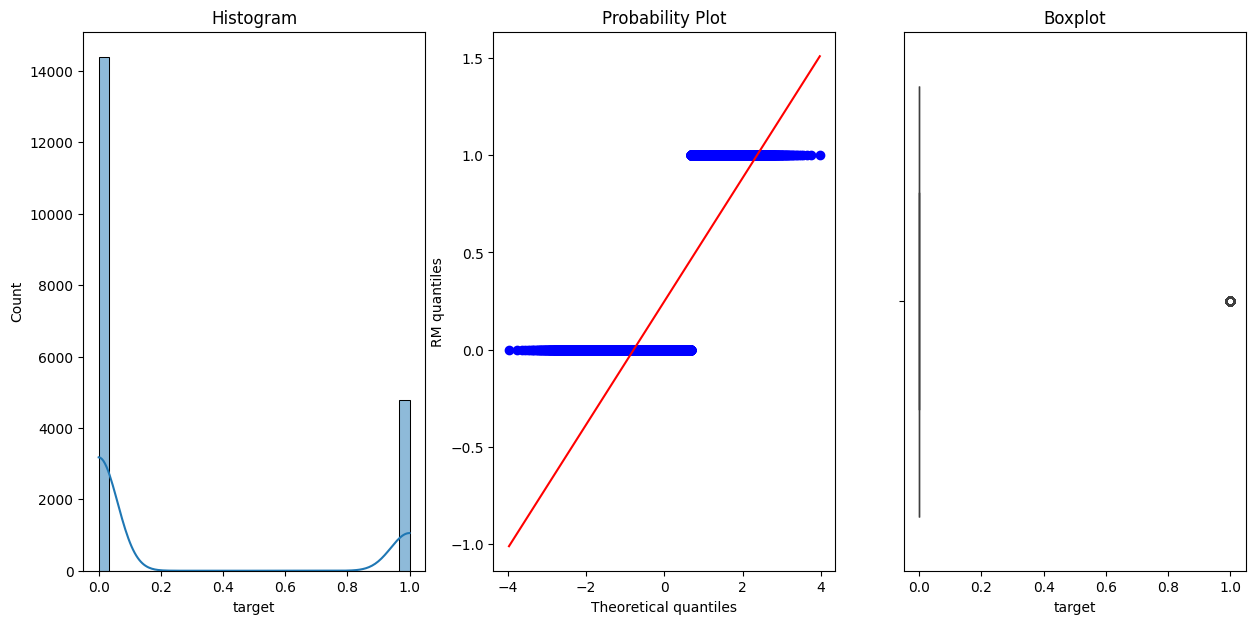

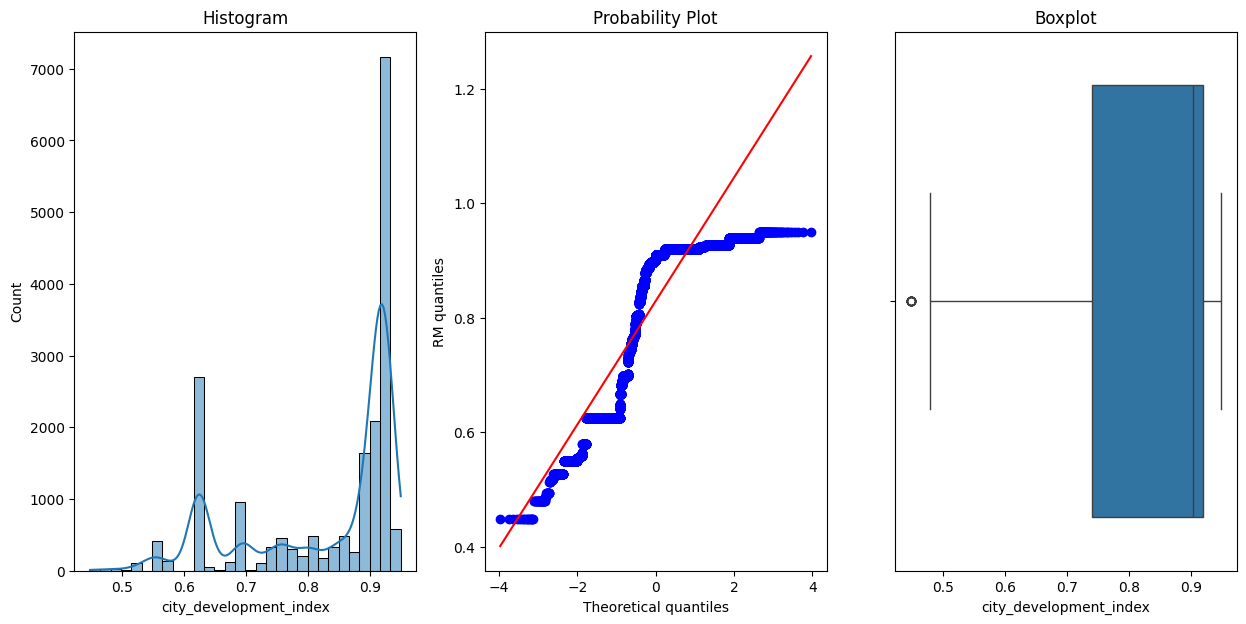

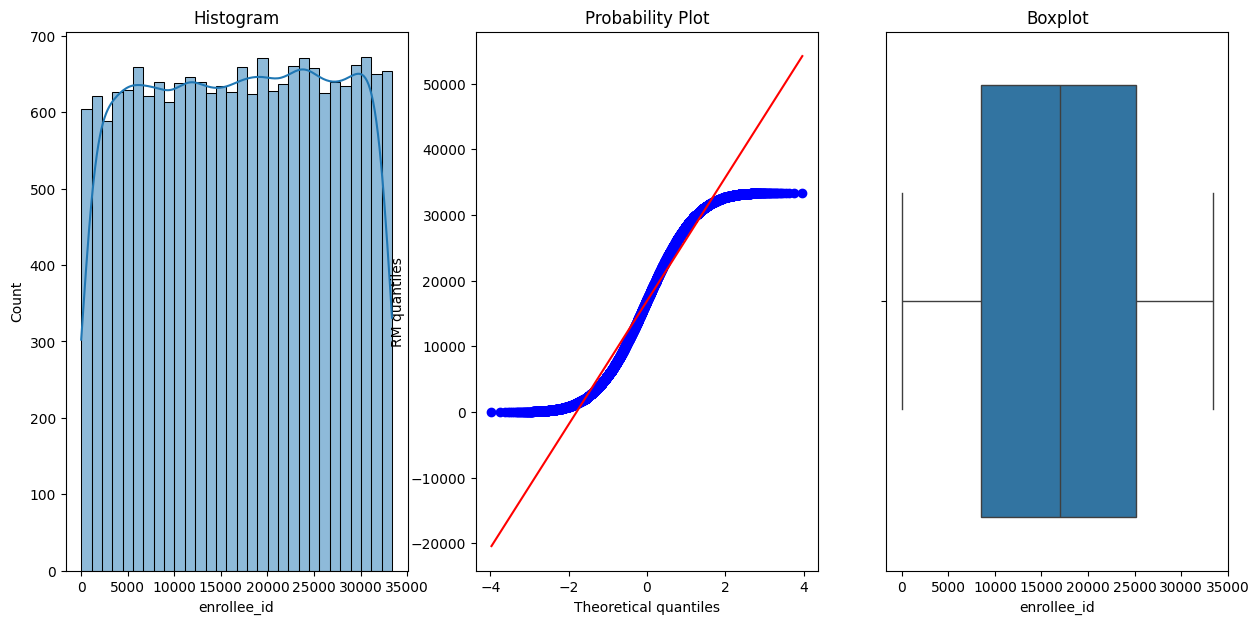

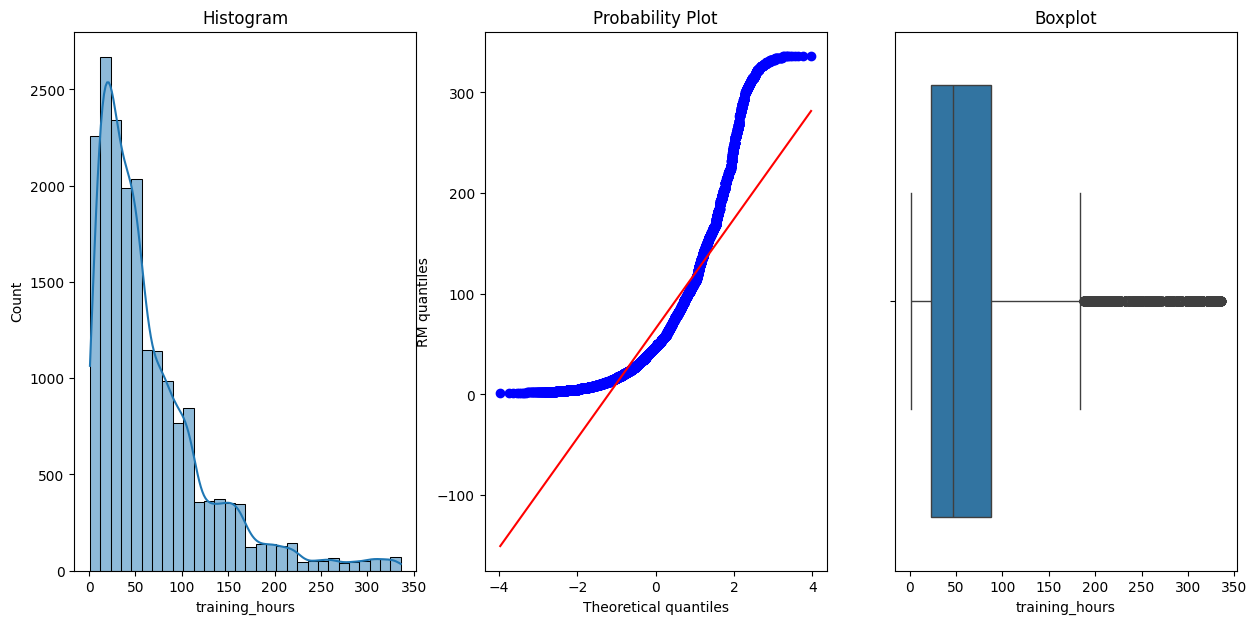

In [ ]:
# Plotting numerical feature with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'enrollee_id':
        plt.figure(figsize=(15,7))

        plt.subplot(1, 3, 1)
        sns.histplot(data=data, x=feature, bins=30, kde=True)
        plt.title('Histogram')

        plt.subplot(1, 3, 2)
        stats.probplot(data[feature], dist="norm", plot=plt)
        plt.ylabel('RM quantiles')

        plt.subplot(1, 3, 3)
        sns.boxplot(x=data[feature])
        plt.title('Boxplot')

plt.show()

*After ploting histogram probability distribution and box plot to find numerical value are in normally distribution and our dataset has no outlier dataset. So, we don't want to remove the outlier in our dataset*

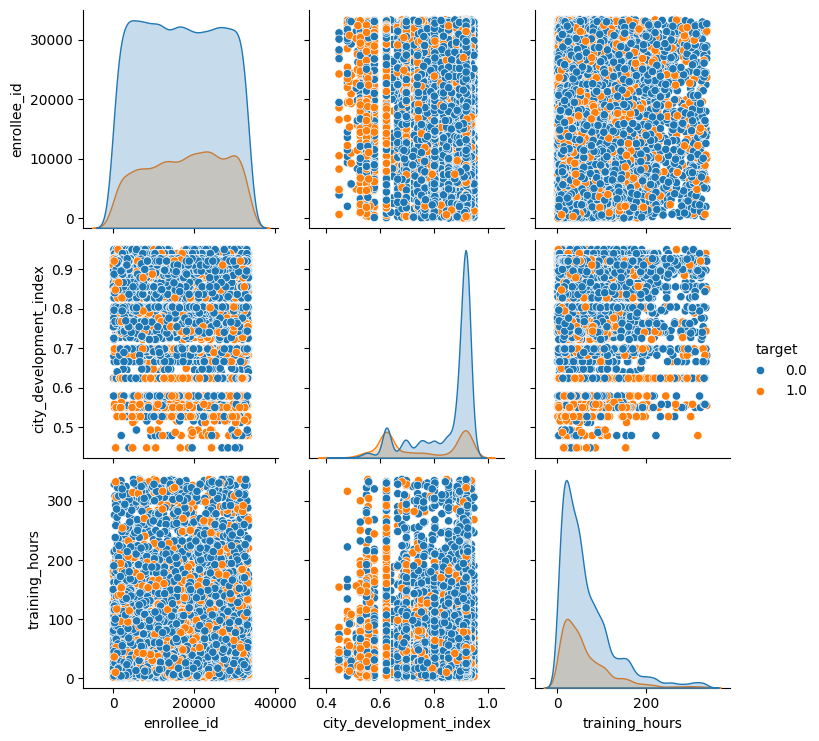

In [ ]:
sns.pairplot(data.drop(columns='company_size'),hue='target', kind='scatter')
plt.show()

#### **Univariate Analysis:**

<Figure size 640x480 with 0 Axes>

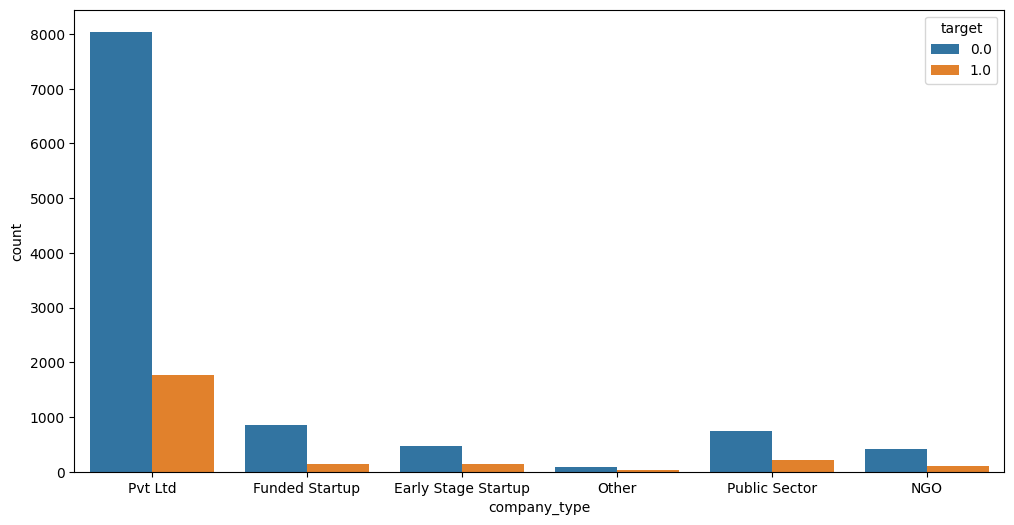

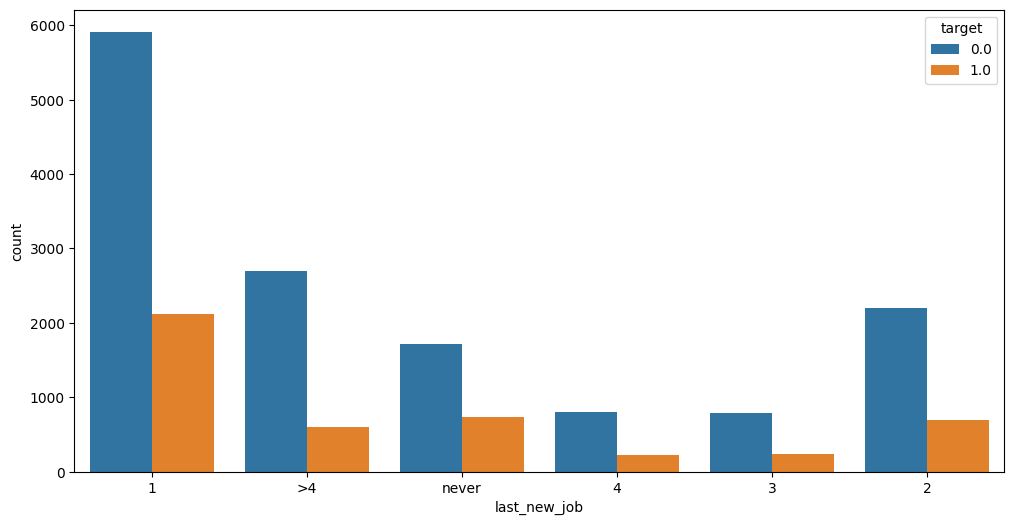

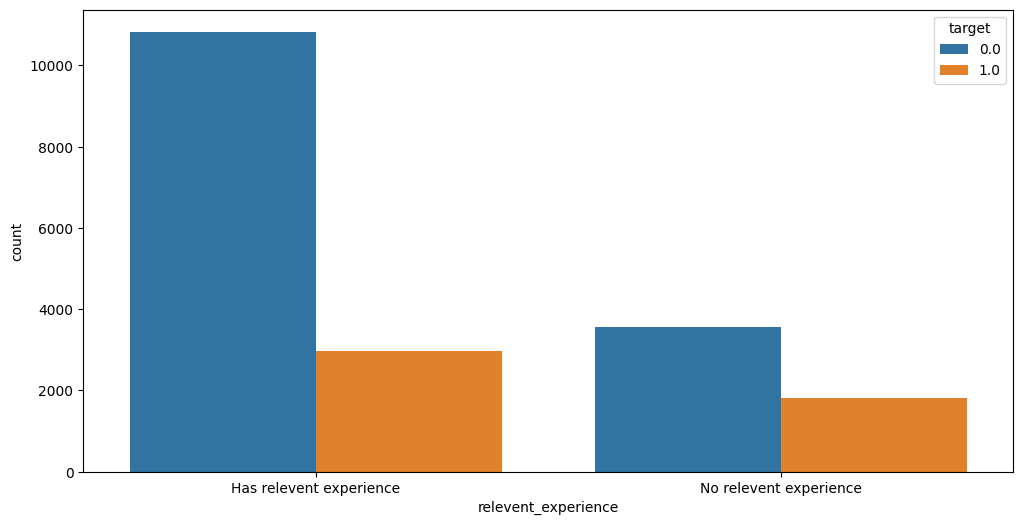

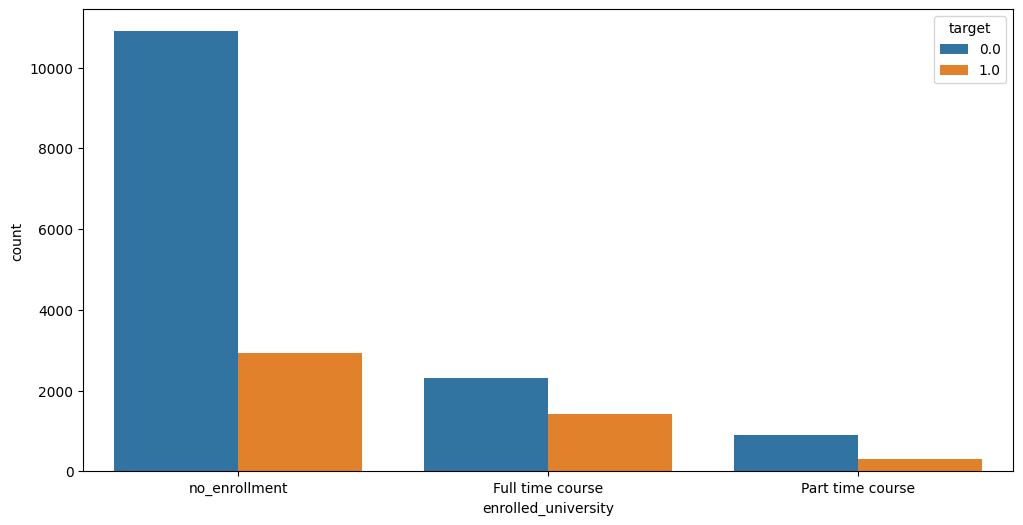

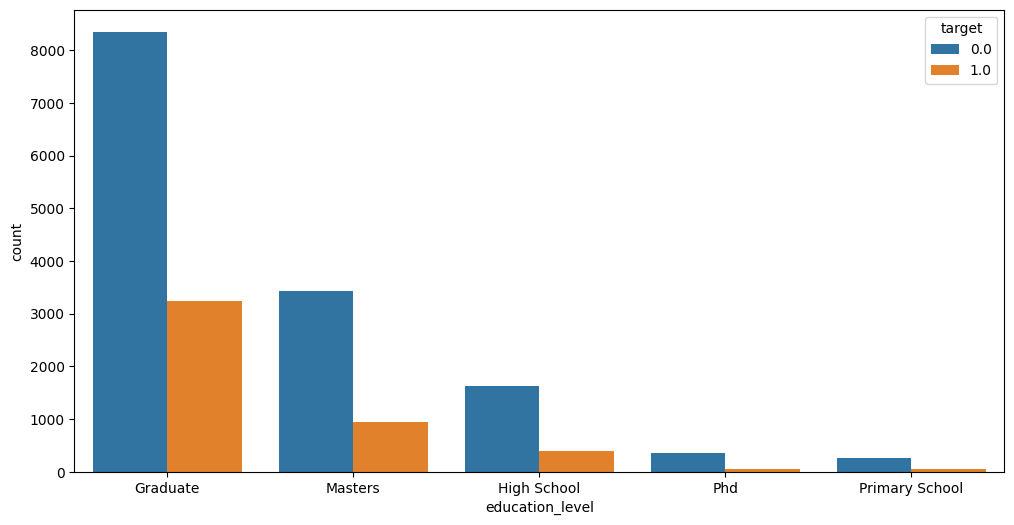

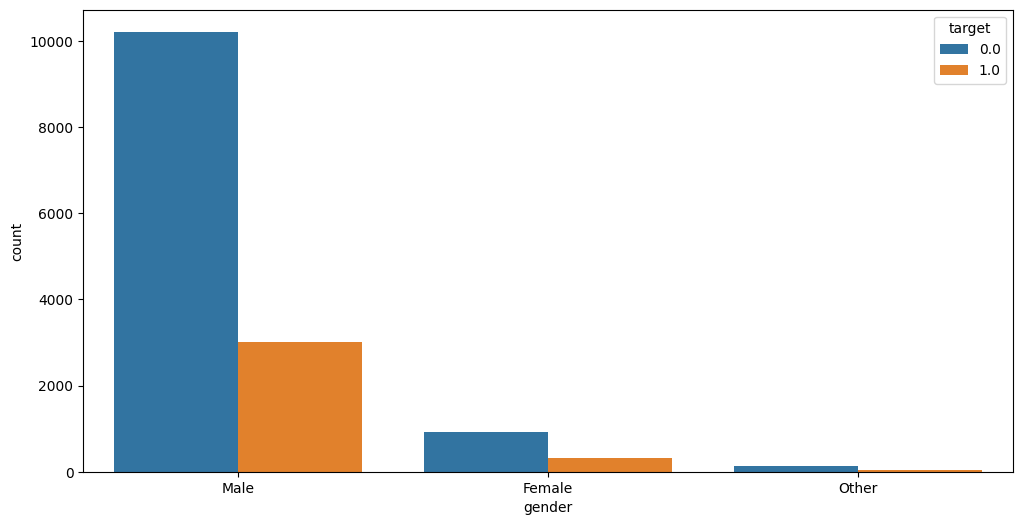

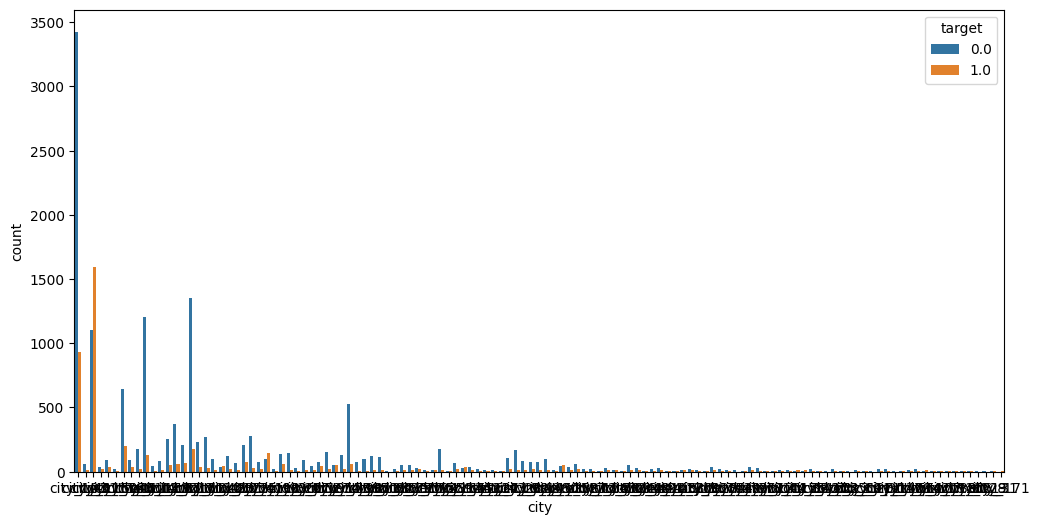

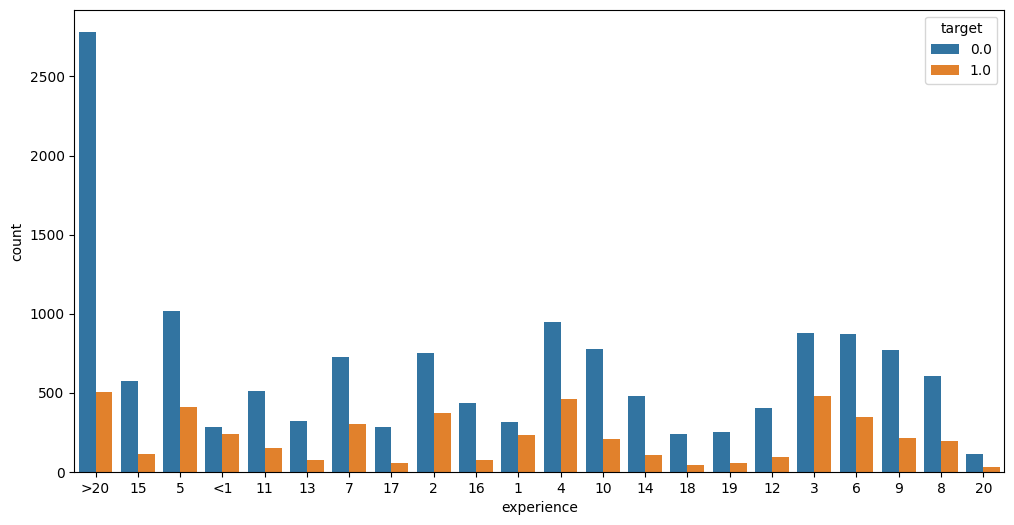

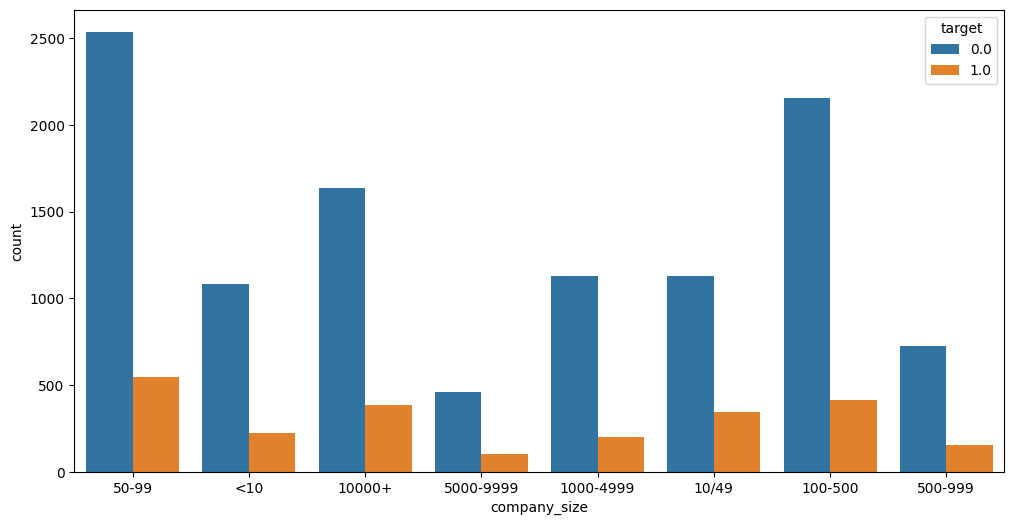

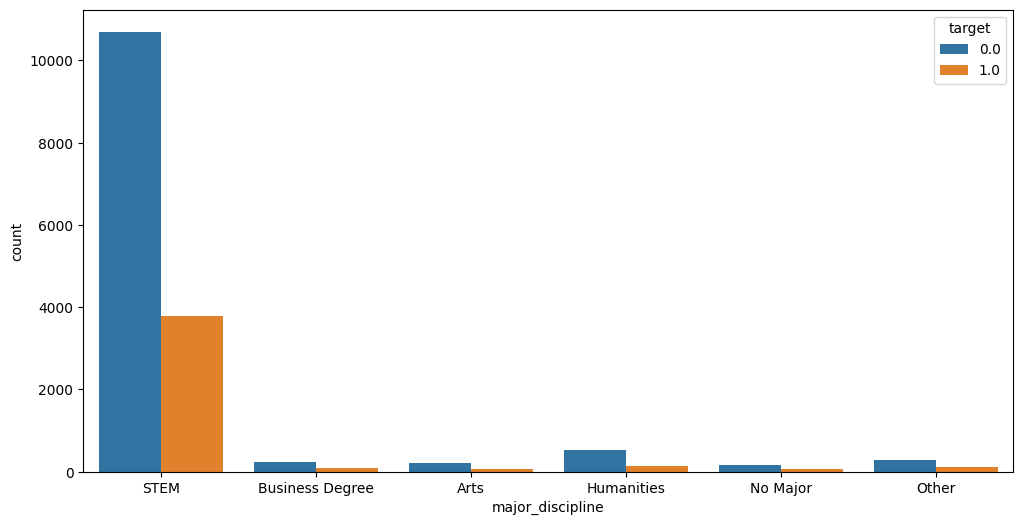

In [ ]:
for i, feature in enumerate(categorical_feature):
      if feature != 'enrolle_id':
          plt.figure(i)
          plt.figure(figsize=(12,6))
          sns.countplot(data=data, x=feature, hue='target')
plt.show()

**Initial Anlaysis**

1.   The first plot suggests a higher likelihood of employees looking for a job change (target variable = 1) in startup environments (Funded Startup, Early Stage Startup) compared to more stable sectors like Public Sector or NGOs
2.   The second plots shows that employees with more experience (experience) or a longer gap since their last job (last_new_job) might be more likely to seek new opportunities (target variable = 1).

3. Employees in less developed cities (lower city_development_index) or those who haven't changed jobs recently (higher last_new_job) might be more likely to consider new opportunities (target variable = 1)

4. Employees in STEM are more prone to churning

5. Male Employees have higher churn rates as compared to their female counterparts

6. The graph suggests employees who completed more training hours (training_hours) might be less likely to be looking for a job change (target = 0), indicating investment in training might be a retention strategy for Pear Inc.



#### **Data Pre-Processing:**

In [ ]:
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
data.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [ ]:
print(categorical_feature)

{'company_type', 'last_new_job', 'relevent_experience', 'enrolled_university', 'education_level', 'gender', 'city', 'experience', 'company_size', 'major_discipline'}


In [ ]:
encoder = LabelEncoder()
for feature in categorical_feature:
    data[feature] = encoder.fit_transform(data[feature])

In [ ]:
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1,0,2,0,5,21,8,6,0,36,1.0
1,29725,77,0.776,1,1,2,0,5,6,4,5,4,47,0.0
2,11561,64,0.624,3,1,0,0,5,15,8,6,5,83,0.0
3,33241,14,0.789,3,1,3,0,1,20,8,5,5,52,1.0
4,666,50,0.767,1,0,2,2,5,21,4,1,3,8,0.0


In [ ]:
data.drop(columns=['enrollee_id'], inplace=True)

<Axes: >

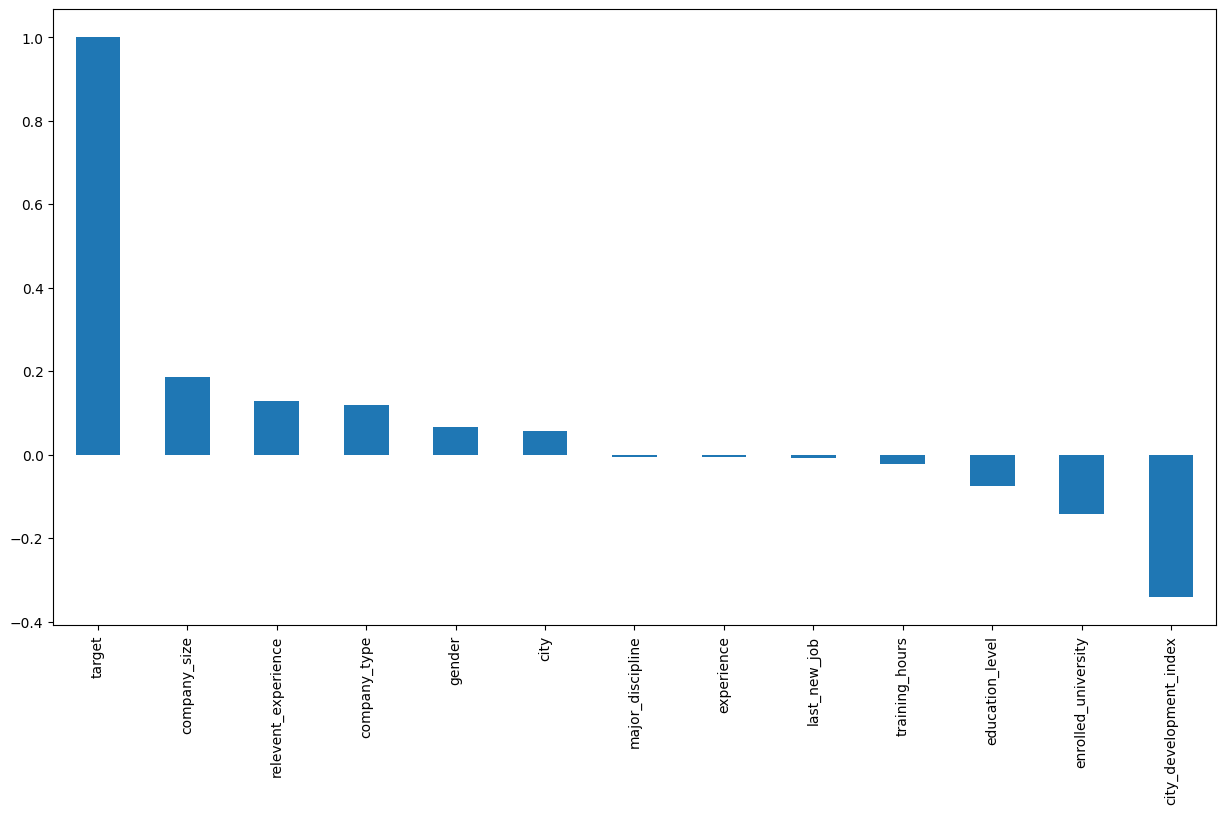

In [ ]:
# Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
data.corr()['target'].sort_values(ascending = False).plot(kind='bar')

<Axes: >

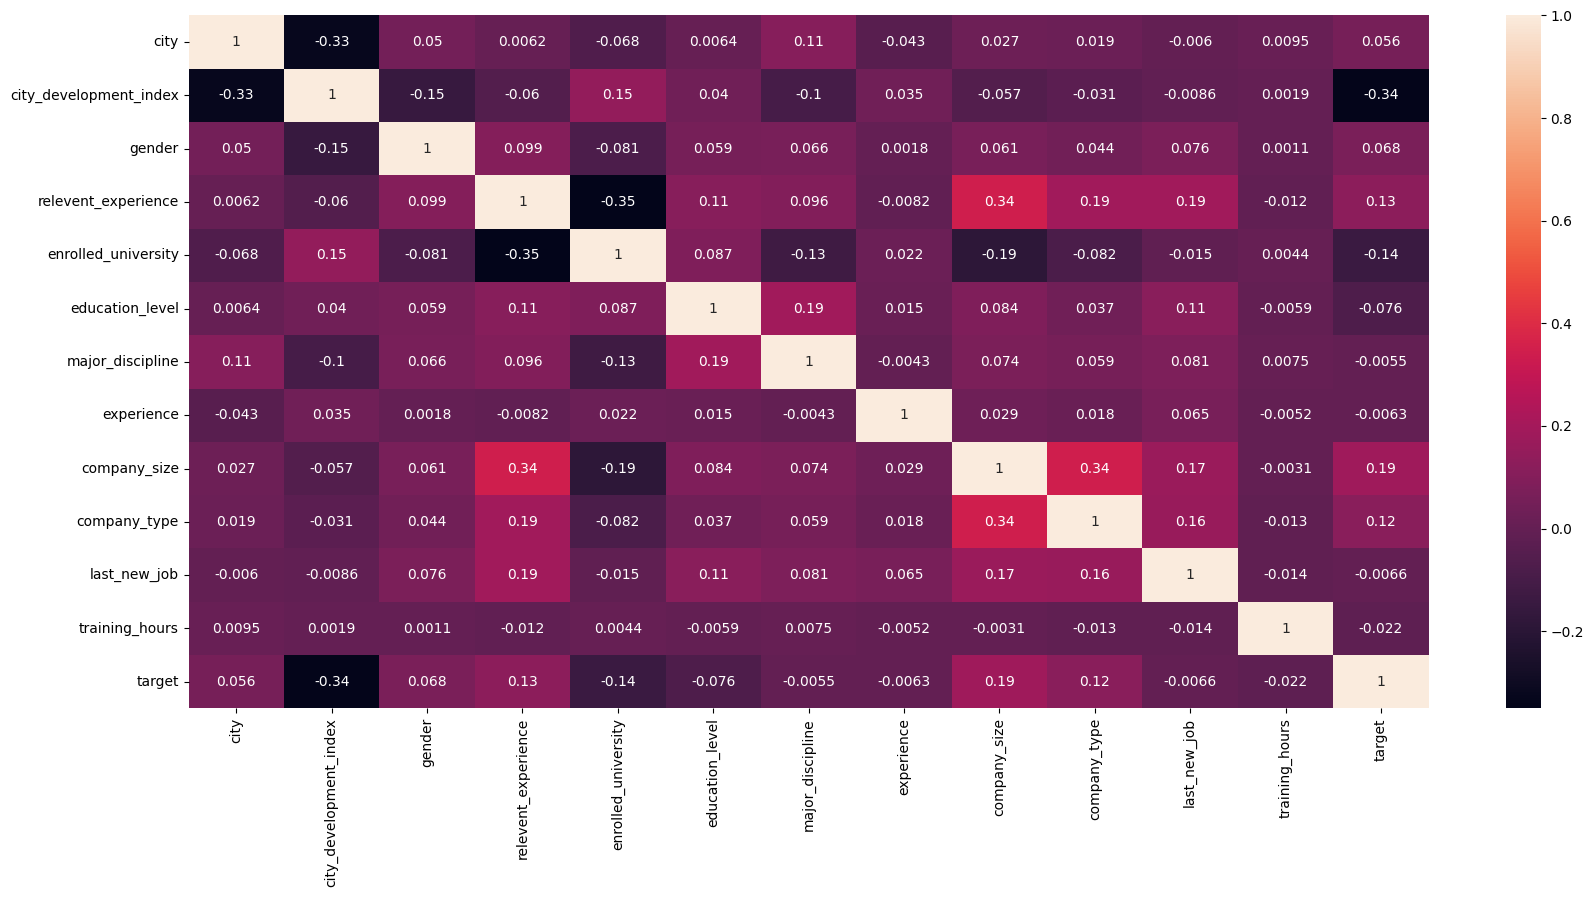

In [ ]:
# Finding the correlation between the independent and dependent feature
plt.figure(figsize=(20, 9))
sns.heatmap(data.corr(), annot=True)

In [ ]:
# Selects the feature which are highly correlated
selection = SelectKBest()  # k=10 default
X = selection.fit_transform(X,y)

In [ ]:
# This shows which features are taken(denoted as True) other are removed(denoted as false)
selection.get_support()

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True])

#### **Data Splitting:**


*   70% Training Data
*   30% Testing Data





In [ ]:
# Splitting dataset into dependent and independent feature
X = data.drop(columns='target')
y = data['target']

In [ ]:
X.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,5,0.920,1,0,2,0,5,21,8,6,0,36
1,77,0.776,1,1,2,0,5,6,4,5,4,47
2,64,0.624,3,1,0,0,5,15,8,6,5,83
3,14,0.789,3,1,3,0,1,20,8,5,5,52
4,50,0.767,1,0,2,2,5,21,4,1,3,8


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=20)

In [ ]:
X_train.shape

(13410, 10)

In [ ]:
X_test.shape

(5748, 10)

#### **Using different ML Algorithms:**

In [ ]:
# Logistic Regression
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.7726165622825331
Confusion matrix :
 [[4063 1005]
 [ 302  378]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      5068
         1.0       0.27      0.56      0.37       680

    accuracy                           0.77      5748
   macro avg       0.60      0.68      0.61      5748
weighted avg       0.85      0.77      0.80      5748



In [ ]:
# Random forest classifier
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.8025400139178844
Confusion matrix :
 [[3803  573]
 [ 562  810]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      4376
         1.0       0.59      0.59      0.59      1372

    accuracy                           0.80      5748
   macro avg       0.73      0.73      0.73      5748
weighted avg       0.80      0.80      0.80      5748



In [ ]:
# Decision Tree Classifier
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.7881002087682673
Confusion matrix :
 [[3875  728]
 [ 490  655]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.89      0.84      0.86      4603
         1.0       0.47      0.57      0.52      1145

    accuracy                           0.79      5748
   macro avg       0.68      0.71      0.69      5748
weighted avg       0.81      0.79      0.80      5748



*We need to over sample the dataset for reducing the TN, FN and increase the FP and TP for better results*

### **Using SMOTE for sorting data imbalance:**
     Over-sampling using SMOTE and cleaning using ENN. Combine over and under sampling using SMOTE and Edited Nearest Neighbours

In [ ]:
st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0.0: 10016, 1.0: 3394})
The number of classes after fit Counter({1.0: 7147, 0.0: 4831})


In [ ]:
#Splitting the over-sampled dataset
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.3, random_state=1)

In [ ]:
#Decision Tree Classifier
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9001112966054535
Confusion matrix :
 [[1357  216]
 [ 143 1878]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      1573
         1.0       0.90      0.93      0.91      2021

    accuracy                           0.90      3594
   macro avg       0.90      0.90      0.90      3594
weighted avg       0.90      0.90      0.90      3594



In [ ]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9190317195325542
Confusion matrix :
 [[1385  176]
 [ 115 1918]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      1561
         1.0       0.92      0.94      0.93      2033

    accuracy                           0.92      3594
   macro avg       0.92      0.92      0.92      3594
weighted avg       0.92      0.92      0.92      3594



In [ ]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.8230383973288815
Confusion matrix :
 [[1162  298]
 [ 338 1796]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.77      0.80      0.79      1460
         1.0       0.86      0.84      0.85      2134

    accuracy                           0.82      3594
   macro avg       0.82      0.82      0.82      3594
weighted avg       0.82      0.82      0.82      3594



In [ ]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sap, y_train_sap)
pred = gbc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9248747913188647
Confusion matrix :
 [[1391  161]
 [ 109 1933]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      1552
         1.0       0.92      0.95      0.93      2042

    accuracy                           0.92      3594
   macro avg       0.93      0.92      0.92      3594
weighted avg       0.92      0.92      0.92      3594



**From these results, we get great accuraccy and TP/FP ratio also increases in GradientBoostClassifier. So, we perform HyperParameter Tunning for this model only**

In [ ]:
param_grid = {'n_estimators':[100, 150, 200, 250, 300],
             'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
             'min_samples_split': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf': [1,3,5,7,9,11,13,15],'max_leaf_nodes': [3,6,8,9,12,15,18,24],
              'max_depth': [3,5,7,9,11,13,15,17,19],
              'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'loss': ['deviance', 'exponential']
              }

In [ ]:
gbc_optm = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid,n_iter=100, verbose=3)
gbc_optm.fit(X_train_sap, y_train_sap)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.3, loss=exponential, max_depth=19, max_leaf_nodes=15, min_samples_leaf=11, min_samples_split=10, n_estimators=250;, score=nan total time=

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_leaf_nodes': [3, 6, 8, 9, 12, 15,
                                                           18, 24],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   verbose=3)

In [ ]:
gbc_optm.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=11,
                           max_leaf_nodes=18, min_samples_leaf=9,
                           n_estimators=300)

In [ ]:
# GradientBoostingClassifier
gbc_tunning = GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=11,
                           max_leaf_nodes=18, min_samples_leaf=9,
                           n_estimators=300)
gbc_tunning.fit(X_train_sap, y_train_sap)
pred = gbc_tunning.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9485253199777407
Confusion matrix :
 [[1426  111]
 [  74 1983]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1537
         1.0       0.95      0.96      0.96      2057

    accuracy                           0.95      3594
   macro avg       0.95      0.95      0.95      3594
weighted avg       0.95      0.95      0.95      3594



**After Oversampling the dataset our model performs is pretty good. From our 4 model GradientBoostClassifier performs better than all. So we dumb our model using pickle library**

#### **Model Saving:**

In [ ]:
import pickle

In [ ]:
filename = 'Model.sav'
pickle.dump(gbc_tunning, open(filename,'wb'))

In [ ]:
load_model = pickle.load(open(filename, 'rb'))

In [ ]:
load_model.score(X_test_sap, y_test_sap)

0.9485253199777407

### **Testing Churn Probabilities:**

In [ ]:
# Testing with highly co-related features (Using sample 12 from churn.csv)
city = 'city_21'
city_development_index = 0.624
gender = 'Full time course'
relevent_experience = 'No relevent experience'
enrolled_university = 'Full time course'
education_level = 'High School'
# major_discipline = 'STEM'
company_size = '10000+'
# experience = '2'
company_type = ''
last_new_job = 'never'
training_hours = 32

In [ ]:
data = [[city,
        gender,
        relevent_experience,
        enrolled_university,
        education_level,
        city_development_index,
        company_size,
        company_type,
        last_new_job,
        training_hours]]

In [ ]:
df = pd.DataFrame(data, columns=['city',
        'gender',
        'relevent_experience',
        'education_level',
        'major_discipline',
        'company_size',
        'experience',
        'company_type',
        'last_new_job',
        'training_hours'])
df.head()
print(df.dtypes)

city                    object
gender                  object
relevent_experience     object
education_level         object
major_discipline        object
company_size           float64
experience              object
company_type            object
last_new_job            object
training_hours           int64
dtype: object


In [ ]:
for feature in df.columns:
    if df[feature].dtypes == 'O':
        categorical_feature = feature
        print(categorical_feature)

city
gender
relevent_experience
education_level
major_discipline
experience
company_type
last_new_job


In [ ]:
encoder = LabelEncoder()
for feature in df.columns:
    if df[feature].dtypes == 'O':
        df[feature] = encoder.fit_transform(df[feature])

In [ ]:
df.head()

,city,gender,relevent_experience,education_level,major_discipline,company_size,experience,company_type,last_new_job,training_hours
0,0,0,0,0,0,0.624,0,0,0,32


In [ ]:
single = load_model.predict(df)
probability = load_model.predict_proba(df)[:,1]

In [ ]:
print(single)

[1.]


In [ ]:
print(probability)

[0.9776906]


In [ ]:
if single == 1:
    print("The Employee is likely to be Churned.")
    print(f"Confidence level is {np.round(probability*100, 2)}")
else:
    print("The Employee is likely to be Continue.")
    print(f"Confidence level is {np.round(probability*100, 2)}")

The Employee is likely to be Churned.
Confidence level is [97.77]
